# PDEFIND Feature Overview

This notebook provides a simple overview of the PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614.)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v0.13.0?filepath=example%2Ffeature_overview.ipynb)

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
import pysindy as ps
from sklearn.metrics import mean_squared_error
np.random.seed(100)

# Test PDE functionality on the 1D kdV equation
The kdV equation is
$u_t = -6uu_x - u_{xxx}$,
and the data we will be investigating is a two-soliton solution.

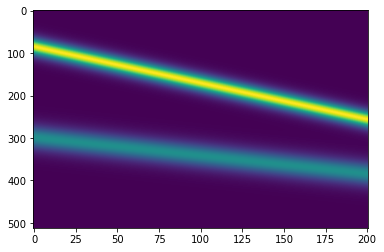

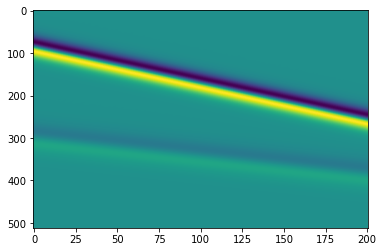

In [2]:
kdV = loadmat('data/kdv.mat')
t = np.ravel(kdV['t'])
x = np.ravel(kdV['x'])
u = np.real(kdV['usol'])
dt = t[1] - t[0]
dx = x[1] - x[0]
plt.figure()
plt.imshow(u, aspect='auto')
u_shaped = np.reshape(u, (len(x), len(t), 1))
plt.figure()
ut = np.zeros((len(x), len(t), 1))
for i in range(len(x)):
    ut[i, :, :] = ps.FiniteDifference()._differentiate(u_shaped[i, :, :], t=dt)
plt.imshow(ut, aspect='auto')

# Randomly choose 80% of the time points for training, remaining points for testing, then solve with all the optimizers

In [3]:
train = np.random.choice(len(t), int(len(t) * 0.8), replace=False)
test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, train]
u_test = u[:, test]
ut_train = ut[:, train]
ut_test = ut[:, test]
t_train = t[train]
t_test = t[test]

# Flatten into 2D shape for SINDy model optimization
u_train_flattened = np.reshape(u_train, (len(x) * len(t_train), 1), 'F')
ut_train_flattened = np.reshape(ut_train, (len(x) * len(t_train), 1), 'F')
u_test_flattened = np.reshape(u_test, (len(x) * len(t_test), 1), 'F')
ut_test_flattened = np.reshape(ut_test, (len(x) * len(t_test), 1), 'F')

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions, function_names=library_function_names, 
                        derivative_order=3, spatial_grid=x, include_bias=True, is_uniform=True, weak_form=True)
# Convert ut_train_flattened into a weak form
ut_train_flattened = pde_lib.ut

optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u_train_flattened, x_dot=ut_train_flattened)
model.print()

# optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
#                    thresholder='l0', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15, 
#                    thresholder='l1', normalize_columns=True)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(normalize_columns=True, L0_penalty=1e-3)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, L0_penalty=1e-3)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

# optimizer = ps.FROLS(normalize_columns=True, L0_penalty=1e-4)
# model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# model.fit(u_train_flattened, x_dot=ut_train_flattened)
# model.print()

ValueError: Found input variables with inconsistent numbers of samples: [16000, 81920]